In [86]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
from datetime import datetime

In [87]:
img_src_folder = "lung-segmentation/uniq"
os.listdir(img_src_folder)

['p17',
 'p5',
 'p7',
 'multigif.py',
 'p13',
 'p11',
 'p16',
 'p6',
 'p8',
 'p15',
 'p14',
 'p1',
 'p4',
 'p18',
 'p3',
 'p19',
 'p12',
 'p9',
 'p10',
 'p2',
 'gifs.zip',
 'p20']

In [88]:
#1-5: normal patients, 11-20: covid patients.
normal_patients = []
covid_patients = []
for root, dirs, files in os.walk(img_src_folder):
    for d in dirs:
        if d[0] == 'p':
            num = int(d[1:])
            if num <= 5: normal_patients.append(d)
            elif num >= 11: covid_patients.append(d)


In [89]:
sorted(normal_patients)

['p1', 'p2', 'p3', 'p4', 'p5']

In [90]:
sorted(covid_patients)

['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']

In [91]:
now = datetime.now()
#defining the minimum number of patients of each class that will be in the test set.
test_patients_per_label = 0
#building the test set with the declared num of patients of each class
TEST_IMG_FOLDERS = sorted(normal_patients)[0:test_patients_per_label]
TEST_IMG_FOLDERS = sorted(covid_patients)[0:test_patients_per_label]

#splitting the test data and the rest (training and validation)
if test_patients_per_label > 0:
    for n in range(test_patients_per_label):
        normal_patients.pop(0)
        covid_patients.pop(0)
        
#defining the number of patients in training set
num_train_patients = int(0.8*min(len(normal_patients), len(covid_patients)))
        
train_normal_folders = sorted(normal_patients)[0:num_train_patients]
train_label_1 = ['normal' for i in range(len(train_normal_folders))]

validation_normal_folders = list(set(normal_patients) - set(train_normal_folders))
validation_label_1 = ['normal' for i in range(len(validation_normal_folders))]

train_covid_folders = sorted(covid_patients)[0:num_train_patients]
train_label_2 = ['covid' for i in range(len(train_covid_folders))]

validation_covid_folders = list(set(covid_patients) - set(train_covid_folders))
validation_label_2 = ['covid' for i in range(len(validation_covid_folders))]

#balancing validation set members for each label (normal or covid)
label_1_size = len(validation_normal_folders)
label_2_size = len(validation_covid_folders)
dif = label_1_size - label_2_size
if dif != 0:
    greater_label = validation_normal_folders #supposing one label as having more elements
    if label_2_size > label_1_size:
        greater_label = validation_covid_folders
        dif = abs(dif)
    for n in range(dif): #deletes an random majoritary's label patient until labels are balanced
        index = random.randint(0, len(greater_label) - 1)
        TEST_IMG_FOLDERS.append(greater_label[index])
        greater_label.pop(index)

TRAIN_IMG_SRC_FOLDER = img_src_folder
VALIDATION_IMG_SRC_FOLDER = img_src_folder
TEST_IMG_SRC_FOLDER = img_src_folder

TRAIN_IMG_FOLDERS = dict(zip(train_normal_folders, train_label_1))
TRAIN_IMG_FOLDERS.update(dict(zip(train_covid_folders, train_label_2)))

VALIDATION_IMG_FOLDERS = dict(zip(validation_normal_folders, validation_label_1))
VALIDATION_IMG_FOLDERS.update(dict(zip(validation_covid_folders, validation_label_2)))

In [92]:
TRAIN_IMG_FOLDERS

{'p1': 'normal',
 'p2': 'normal',
 'p3': 'normal',
 'p4': 'normal',
 'p11': 'covid',
 'p12': 'covid',
 'p13': 'covid',
 'p14': 'covid'}

In [93]:
VALIDATION_IMG_FOLDERS

{'p5': 'normal', 'p18': 'covid'}

In [94]:
TEST_IMG_FOLDERS

['p19', 'p20', 'p16', 'p15', 'p17']

In [95]:
EXAM_SLICE = 200
CLASSES = len(set([label for label in TRAIN_IMG_FOLDERS.values()]))
EPOCHS = 10
width = 150
height = 150
print(CLASSES)

2


In [96]:
dfs = []
train_images = {"id": [], "label": []}
validation_images = {"id": [], "label": []}

df_config = [
    (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS, train_images),
    (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS, validation_images)
]

def get_file_path(folder, search_filter=''):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

for (base, folder, dic) in df_config:
    for img_folder, img_label in folder.items():
        search_folder = "{}/{}".format(base, img_folder)
        imgs_filename = sorted(get_file_path(search_folder, search_filter = 'segmented'))
        imgs_filename = imgs_filename[(len(imgs_filename)-EXAM_SLICE)//2:(len(imgs_filename)+EXAM_SLICE)//2]
        dic["id"].extend(imgs_filename)
        dic["label"].extend([img_label] * len(imgs_filename))
        
    dfs.append(pd.DataFrame(data=dic))

train_df, validation_df = dfs[0], dfs[1]

train_df.to_csv('train_df.csv', index=False)
validation_df.to_csv('validation_df.csv', index=False)

print("Train fold with {} images".format(len(train_df)))
print(train_df.groupby("label").label.count())
print()
print("Validation fold with {} images".format(len(validation_df)))
print(validation_df.groupby("label").label.count())
print("-" * 30)

Train fold with 1600 images
label
covid     800
normal    800
Name: label, dtype: int64

Validation fold with 400 images
label
covid     200
normal    200
Name: label, dtype: int64
------------------------------


Random Visualization of Training Data Samples

In [97]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(width,height))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "normal":"Normal",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

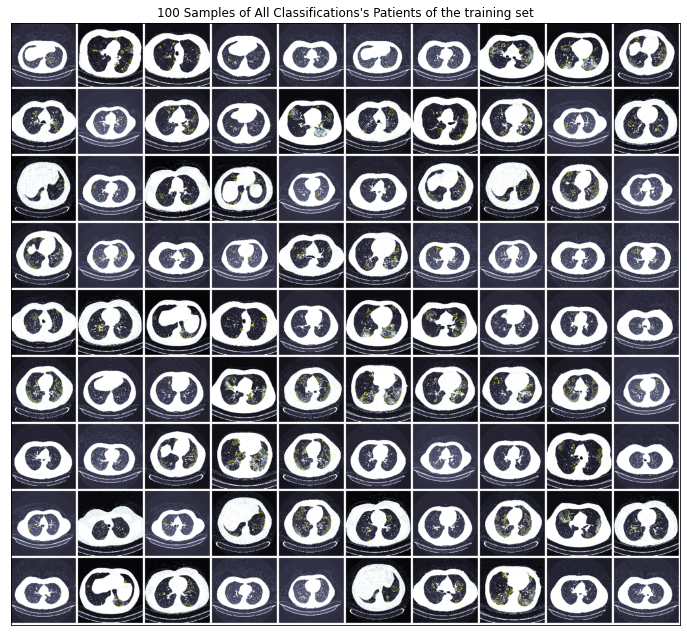

In [98]:
show_gallery("all")

Data Generator

In [99]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1)
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(width, height),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return data_generator

See sample generated images

Found 1 validated image filenames belonging to 1 classes.


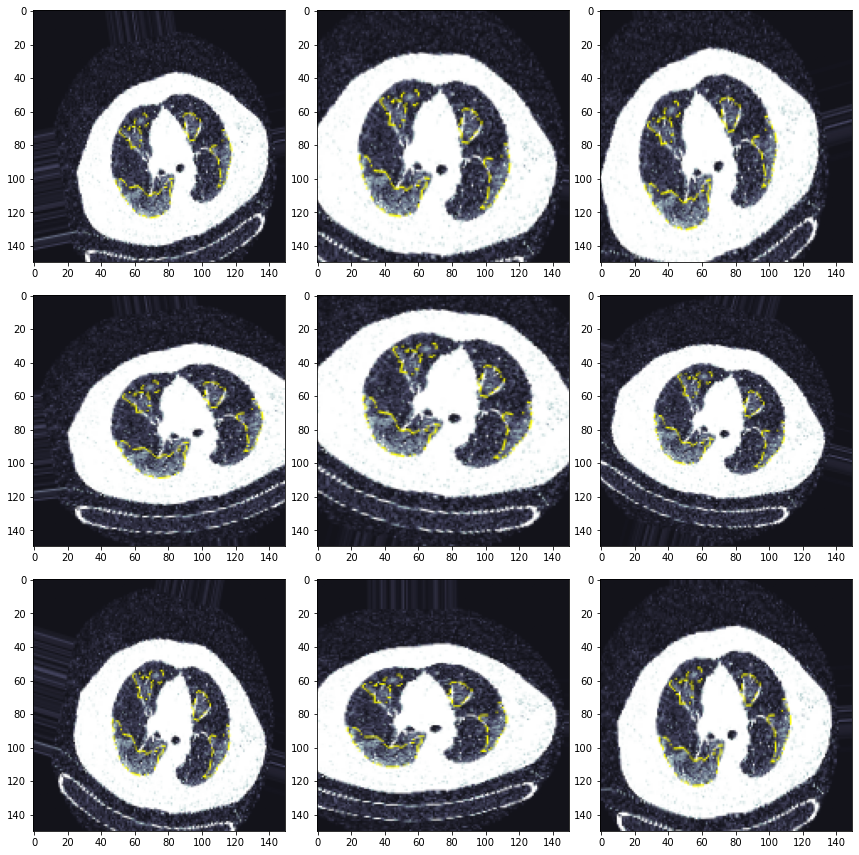

In [100]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = get_data_generator(example_df, "id", "label", class_mode = "categorical")

plt.figure(figsize = (12,12))
for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in example_generator:
            image = X_batch[0]
            plt.imshow(image)
            break
plt.tight_layout()
plt.show()

Building model from scratch

In [101]:
def get_model():
    classifier= Sequential()

    classifier.add(Convolution2D(32, (3, 3), input_shape=(height, width, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(64, (3, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(128, (3, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))
    
    classifier.add(Convolution2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Flatten())

    classifier.add(Dense(units= 512, activation= 'relu'))
    #classifier.add(Dropout(0.1))
    #classifier.add(Dense(units= 128, activation= 'relu'))
    #classifier.add(Dropout(0.1))
    classifier.add(Dense(units= 1, activation= 'sigmoid'))

    classifier.compile(optimizer= 'adam', loss= 'binary_crossentropy' ,metrics= ['accuracy'])
    classifier.summary()

    return classifier

In [102]:
def train_model(model, train_df, validation_df, epochs, callbacks=[]):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size)
    validation_generator = get_data_generator(validation_df, "id", "label",batch_size=batch_size)

    model.compile(
        optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"]
    )

    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2

    history = model.fit(
        train_generator,
        steps_per_epoch=step_size_train,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=callbacks
    )

    return history.history

In [103]:
def plot_results(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

Fitting and Visualizing Results

In [104]:
model = get_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

In [105]:
history = train_model(model, train_df, validation_df, EPOCHS)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 45s 452ms/step - loss: 0.5044 - accuracy: 0.7356 - val_loss: 0.5300 - val_accuracy: 0.7225
Epoch 2/10
100/100 [==============================] - 20s 196ms/step - loss: 0.1744 - accuracy: 0.9250 - val_loss: 0.1898 - val_accuracy: 0.9175
Epoch 3/10
100/100 [==============================] - 18s 182ms/step - loss: 0.0857 - accuracy: 0.9681 - val_loss: 0.5357 - val_accuracy: 0.8100
Epoch 4/10
100/100 [==============================] - 18s 179ms/step - loss: 0.0330 - accuracy: 0.9869 - val_loss: 0.4510 - val_accuracy: 0.8575
Epoch 5/10
100/100 [==============================] - 18s 184ms/step - loss: 0.0691 - accuracy: 0.9775 - val_loss: 0.0899 - val_accuracy: 0.9675
Epoch 6/10
100/100 [==============================] - 18s 185ms/step - loss: 0.0249 - accuracy: 0.9912 - val_loss: 0.3005 - val_accuracy: 0.9075
Epoch 7/1

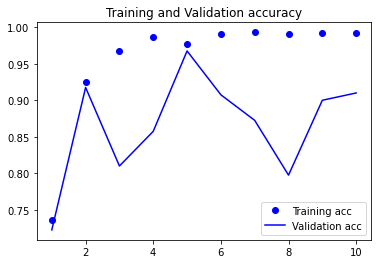

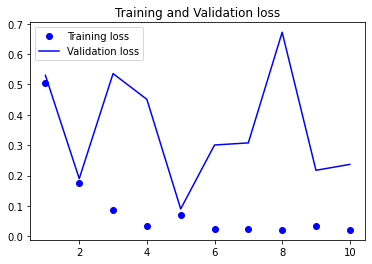

In [106]:
plot_results(history)